In [3]:
from imutils.contours import sort_contours
import numpy as np
import pytesseract
import argparse
import imutils
import sys
import cv2
import json
import jsonpickle
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from IPython.display import display
import math
from skimage.filters import threshold_local
import pathlib
import os

In [7]:
#image_path = "../data/passport_data/test_british.png"
#image_path = "../data/passport_data/passport_1.jpg" #--> working crop=True
#image_path = "../data/passport_data/passport_2.jpg" #--> working crop=False
#image_path = "../data/passport_data/passport_3.jpg" #--> workingcrop=False(not correct mrz) crop=True(better)
#image_path = "../data/passport_data/passport_4.jpg"
#image_path = "../data/passport_data/passport_5.jpg" # --> working crop=False
#image_path = "../data/passport_data/passport_6.jpg"# --> working crop=True
#image_path = "../data/passport_data/passport_7.jpg" #  --> working crop=False
#image_path = "../data/passport_data/passport_8.jpg" #--> not working wrong perspective
image_path = "../data/passport_data/passport_9.jpg" #--> working crop=True
#image_path = "../data/passport_data/passport_10.jpg" #--> working crop=False
#image_path = "../data/passport_data/passport_12.jpg" #--> working crop=True
#image_path = "../data/passport_data/passport_11.jpg"# --> working crop=False
#image_path = "../data/passport_data/rotated_passport.jpg"
filename = pathlib.Path(image_path).stem
save_path = os.path.join("../data/passport_data/",f"{filename}_pers.jpg")

In [8]:
def show_image(image,cmap=""):
    if not cmap:
        plt.imshow(image)
    else:
        plt.imshow(image,cmap=cmap)

    # display that image
    plt.show()

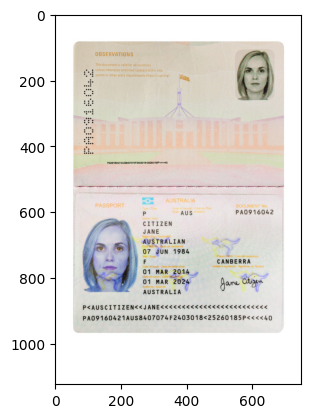

In [9]:
show_image(cv2.imread(image_path))

In [11]:
def perspective_image(image_path,save_path):
    def order_points(pts):
        # initialzie a list of coordinates that will be ordered
        # such that the first entry in the list is the top-left,
        # the second entry is the top-right, the third is the
        # bottom-right, and the fourth is the bottom-left
        rect = np.zeros((4, 2), dtype = "float32")

        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        # now, compute the difference between the points, the
        # top-right poi
        # nt will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        # return the ordered coordinates
        return rect
    
    def four_point_transform(image, pts):
        # obtain a consistent order of the points and unpack them
        # individually
        rect = order_points(pts)
        (tl, tr, br, bl) = rect

        # compute the width of the new image, which will be the
        # maximum distance between bottom-right and bottom-left
        # x-coordiates or the top-right and top-left x-coordinates
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        # compute the height of the new image, which will be the
        # maximum distance between the top-right and bottom-right
        # y-coordinates or the top-left and bottom-left y-coordinates
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        # now that we have the dimensions of the new image, construct
        # the set of destination points to obtain a "birds eye view",
        # (i.e. top-down view) of the image, again specifying points
        # in the top-left, top-right, bottom-right, and bottom-left
        # order
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")

        # compute the perspective transform matrix and then apply it
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

        # return the warped image
        return warped
    # read the input image
    image = cv2.imread(image_path)

    # clone the original image
    original_image = image.copy()

    # resize using ratio (old height to the new height)
    ratio = image.shape[0] / 500.0
    image = imutils.resize(image, height=500)
    #  change the color space to YUV
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # grap only the Y component
    image_y = np.zeros(image_yuv.shape[0:2], np.uint8)
    image_y[:, :] = image_yuv[:, :, 0]
    # blur the image to reduce high frequency noises
    image_blurred = cv2.GaussianBlur(image_y, (3, 3), 0)
    # find edges in the image
    edges = cv2.Canny(image_blurred, 50, 200, apertureSize=3)
    # find contours
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # draw all contours on the original image
#     cv2.drawContours(image, contours, -1, (0, 255, 0), 1)
    # !! Attention !! Do not draw contours on the image at this point
    # I have drawn all the contours just to show below image
    # to collect all the detected polygons
    polygons = []

    # loop over the contours
    for cnt in contours:
        # find the convex hull
        hull = cv2.convexHull(cnt)

        # compute the approx polygon and put it into polygons
        polygons.append(cv2.approxPolyDP(hull, 0.01 * cv2.arcLength(hull, True), False))
    # sort polygons in desc order of contour area
    sortedPoly = sorted(polygons, key=cv2.contourArea, reverse=True)

#     # draw points of the intersection of only the largest polyogon with red color
#     cv2.drawContours(image, sortedPoly[0], -1, (0, 0, 255), 5)
    
    # get the contours of the largest polygon in the image
    simplified_cnt = sortedPoly[0]
    print(simplified_cnt)
    # check if the polygon has four point
    if len(simplified_cnt) == 4:
        # trasform the prospective of original image
        cropped_image = four_point_transform(original_image, simplified_cnt.reshape(4, 2) * ratio)
    else:
        cropped_image=image
    
    # Binarize the cropped image
    gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray_image, 11, offset=10, method="gaussian")
    binarized_image = (gray_image > T).astype("uint8") * 255
    # Show images
#     show_image(original_image)
#     show_image(binarized_image)
#     show_image(cropped_image)
    #print("save_path= ",save_path)
    cv2.imwrite(save_path,cropped_image)
    return cropped_image

In [12]:
perspective_image = perspective_image(image_path,save_path)

[[[308 422]]

 [[ 24 425]]

 [[ 26  39]]

 [[308  42]]]


In [13]:
#perspective_image = cv2.imread(image_path)

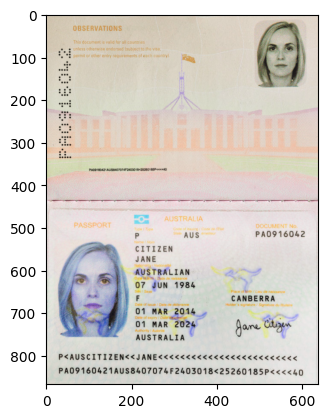

In [14]:
show_image(perspective_image)

In [15]:
def rotate_image(image, angle):
    # Get image dimensions
    height, width = image.shape[:2]

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), -angle, 1)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    return rotated_image


In [16]:

def detect_and_draw_horizontal_lines(image, threshold=100):
    # Load the image
    #image = cv2.imread(image_path)
    temp_image = image.copy()
   # Convert the image to grayscale
    gray = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Apply Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=threshold, minLineLength=100, maxLineGap=10)

    # Find the longest horizontal line
    longest_line = None
    longest_line_length = 0
    for line in lines:
        x1, y1, x2, y2 = line[0]
        line_length = abs(x2 - x1)
        if line_length > longest_line_length: #and abs(y2 - y1) < 10:  # Filter out non-horizontal lines
            longest_line = line
            longest_line_length = line_length

    # Draw the longest horizontal line on the image
    if longest_line is not None:
        x1, y1, x2, y2 = longest_line[0]
        #cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 3)
    
#         # Calculate the angle of the line
#         angle = math.atan2(y2 - y1, x2 - x1) * 180 / np.pi
#         angle = abs(angle)  # Ensure positive angle
        # Calculate the angle of the line in degrees
        angle = math.atan2(y2 - y1, x2 - x1) * 180 / np.pi
        angle = abs(angle)  # Ensure positive angle
        
#         # Rotate the image
#         rotated_image = rotate_image(image, angle)
#         # Display the angle on the image
        text = f"Angle: {angle:.2f} degrees"
        #cv2.putText(temp_image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        print(text)
        show_image(temp_image)
    return angle

In [17]:
def tune_image(image):
    original_image = image.copy()
    angle = detect_and_draw_horizontal_lines(original_image)
    if angle >3.0:
        rotated_image = rotate_image(original_image , angle)
        show_image(rotated_image)
        return rotated_image
    else:
        return original_image

Angle: 0.00 degrees


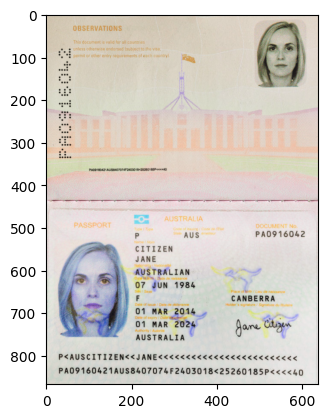

In [18]:
tuned_image = tune_image(perspective_image)

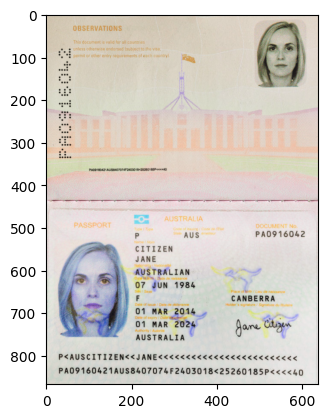

In [19]:
show_image(tuned_image)

In [20]:
def detect_face_bbox(image):
    # Load the cascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    # Detect faces
    faces = face_cascade.detectMultiScale(image, 1.1, 4)
    # Draw rectangle around the faces
    print(image.shape[:2])
    print(faces)
    if len(faces):
        for (x, y, w, h) in faces: 
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
            # Export the result
        cv2.imwrite("face_detected.png", image) 
        print('Successfully saved')
        crop_image = image[(y+h):image.shape[0],:]
        show_image(crop_image)
        return crop_image
    else:
        return image

(867, 638)
[[500  41 103 103]
 [ 34 568 149 149]]
Successfully saved


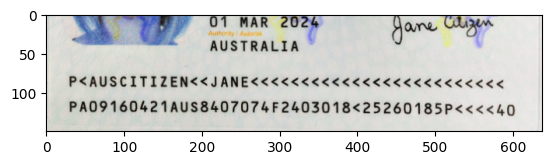

In [21]:
cropped_face_image = detect_face_bbox(tuned_image)

In [2077]:

# def split_passport(image_path):
#     def discard(image):
#         image = np.uint8(image)
#         _, im_label, stts, _ = cv2.connectedComponentsWithStats(image, connectivity=4)

#         msk1 = np.isin(im_label, np.where(stts[:, cv2.CC_STAT_WIDTH] > 500)[0])
#         msk2 = np.isin(im_label, np.where(stts[:, cv2.CC_STAT_HEIGHT] > 500)[0])

#         image[(msk1 | msk2)] = 0
#         return image


#     img = cv2.imread(image_path, 0)
#     img = cv2.resize(img, None, fx=0.35, fy=0.35, interpolation=cv2.INTER_LINEAR)
#     height, width = img.shape[:2]

#     # Binarization
#     thresh = 255 - img
#     ret, thresh = cv2.threshold(thresh, 5, 255, cv2.THRESH_BINARY)

#     # Discarding long connected components
#     without_lines = discard(thresh.copy())
#     just_lines = cv2.bitwise_xor(thresh, without_lines)
#     horizontal = just_lines.copy()

#     # separating horizontal line
#     h_kernel_large = np.array([[0, 0, 0, 0, 0],
#                                [0, 0, 0, 0, 0],
#                                [1, 1, 1, 1, 1],
#                                [0, 0, 0, 0, 0],
#                                [0, 0, 0, 0, 0]], np.uint8)
#     horizontal = cv2.morphologyEx(horizontal, cv2.MORPH_OPEN, h_kernel_large, iterations=2)
#     cv2.imwrite("horizontal_line.jpg",horizontal)

In [2078]:
#split_passport(save_path)

In [2079]:
## call perspective
#%run -i rectify.py  passport_rotated.jpg result/passport_rotated_pers.jpg

In [24]:
def resize_image(image, new_width=None, new_height=None):
#     # Load the image
#     image = cv2.imread(image_path)
    
    # Get the original image dimensions
    (height, width) = image.shape[:2]
    
    # Determine the aspect ratio of the image
    aspect_ratio = width / float(height)
    
    # If new_width is provided, resize the image based on it
    if new_width is not None:
        new_height = int(new_width / aspect_ratio)
    # If new_height is provided, resize the image based on it
    elif new_height is not None:
        new_width = int(new_height * aspect_ratio)
    # If both new_width and new_height are None, return the original image
    else:
        return image
    
    # Resize the image while maintaining its aspect ratio
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    
    return resized_image

In [25]:
def extract_mrz(image,crop=False):
    #image = crop_image
    if crop:
        print("In crop")
        # Get the dimensions of the image
        height, width = image.shape[:2]
        # Crop the image in half
        half_height = height // 2
        image = image[half_height:,:]
    #image = cv2.resize(image, (1000, 500))
    image = resize_image(image,1000, 800)
    show_image(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (H, W) = gray.shape
    # initialize a rectangular and square structuring kernel
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 7))
    sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    # smooth the image using a 3x3 Gaussian blur and then apply a
    # blackhat morpholigical operator to find dark regions on a light
    # background
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
    #show_image("Blackhat", blackhat)
    #cv2.imshow("Blackhat", blackhat)
    # compute the Scharr gradient of the blackhat image and scale the
    # result into the range [0, 255]
    grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad = np.absolute(grad)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (grad - minVal) / (maxVal - minVal)
    grad = (grad * 255).astype("uint8")
    show_image(grad,"gray")
    #cv2.imshow("Gradient", grad)
    # apply a closing operation using the rectangular kernel to close
    # gaps in between letters -- then apply Otsu's thresholding method
    grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
    thresh = cv2.threshold(grad, 0, 255,
                           cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
    thresh = cv2.erode(thresh, None, iterations=2)
    show_image(thresh,"gray")
    ## DETERMINE CONTOURS AND FILTER THEM
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    #make a copy of the resized image since we are going to draw contours on the resized image
    resizedImageCopy=np.copy(image)

    # draw all contours with setting the parameter to -1
    # but if you use this function, you should comment the for loop below
    #cv2.drawContours(resizedImageCopy,contours,-1,(0,0,255),2)
    #filter contours 
    for i, c in enumerate(contours):
        areaContour=cv2.contourArea(c)
        if areaContour<2000 or 100000<areaContour:
            continue
        cv2.drawContours(resizedImageCopy,contours,i,(255,10,255),4)
    # # display the original image with contours
    # cv2.imshow('Image', resizedImageCopy)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # cv2.imwrite("resizedPartsContours.png", resizedImageCopy, [cv2.IMWRITE_PNG_COMPRESSION, 0]) 
    show_image(resizedImageCopy,"gray")
    mrzBox = []
    # loop over the contours
    for i,c in enumerate(contours):
        # compute the bounding box of the contour and then derive the
        # how much of the image the bounding box occupies in terms of
        # both width and height
        (x, y, w, h) = cv2.boundingRect(c)
        print('here = ',x,y,w,h)
        percentWidth = w / float(W)
        percentHeight = h / float(H)
        # if the bounding box occupies > 80% width and > 4% height of the
        # image, then assume we have found the MRZ
        print(percentWidth,percentHeight)
        if percentWidth > 0.6 and percentHeight > 0.03 or percentHeight > 0.6 and percentWidth > 0.03:#and y >=H*0.25:
            print('y = ',y)
#             print("% width",percentWidth)
#             print("% height",percentHeight)
            mrzBox.append((x, y, w, h))
    print(mrzBox)
    print(len(mrzBox))
    if len(mrzBox) > 1:
        
        print("combining 2 mrz countors into 1")

        print('mrzBox =',mrzBox)
        x1,y1,w1,h1 = mrzBox[0]
        x2,y2,w2,h2 = mrzBox[1]
        # Calculate the coordinates of the combined rectangle
        x = min(x1, x2)
        y = min(y1, y2)
        width = max(x1 + w1, x2 + w2) - x
        height = max(y1 + h1, y2 + h2) - y
        mrzBox = (x,y,width,height)
    else:
        mrzBox  = mrzBox[0]
#     print("before expanding")
    print("----",mrzBox)
    # if the MRZ was not found, exit the script
    if mrzBox is None:
        print("[INFO] MRZ could not be found")
        sys.exit(0)
    # pad the bounding box since we applied erosions and now need to
    # re-grow it
    (x, y, w, h) = mrzBox
    if w>h:
        pX = int((x + w) * 0.02)
        pY = int((y + h) * 0.02)
#         print("px =",pX)
#         print("py= ",pY)
        (x, y) = (x - pX, y - (pY * 3))
        (w, h) = (w + (pX * 3), h + (pY * 6))
    else:
        pX = int((x + w) * 0.02)
        pY = int((y + h) * 0.02)
#         print("px =",pX)
#         print("py= ",pY)
        (x, y) = (x - (pX*3), y - pY)
        (w, h) = (w + (pX * 6), h + (pY * 3))
#     print("after expanding")
#     print(x,y,w,h)
    # extract the padded MRZ from the image
    mrz = gray[y:y + h, x:x + w]
    mrz_color = cv2.cvtColor(mrz,cv2.COLOR_GRAY2RGB)
    show_image(mrz,"gray")
    return mrz_color,(x,y,w,h)

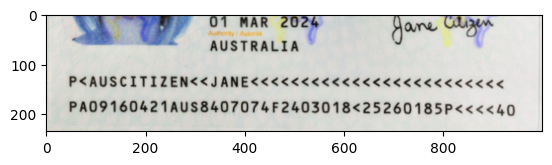

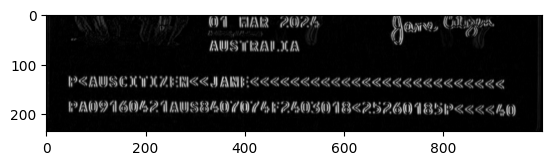

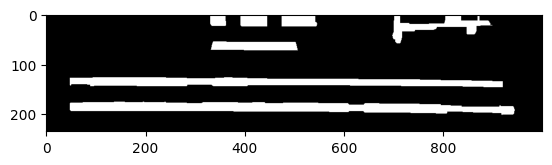

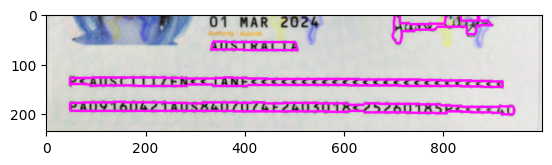

here =  48 176 897 27
0.897 0.1148936170212766
y =  176
here =  48 127 873 20
0.873 0.0851063829787234
y =  127
here =  332 55 176 18
0.176 0.07659574468085106
here =  698 0 202 59
0.202 0.251063829787234
here =  475 0 72 25
0.072 0.10638297872340426
here =  392 0 54 25
0.054 0.10638297872340426
here =  331 0 32 24
0.032 0.10212765957446808
[(48, 176, 897, 27), (48, 127, 873, 20)]
2
combining 2 mrz countors into 1
mrzBox = [(48, 176, 897, 27), (48, 127, 873, 20)]
---- (48, 127, 897, 76)


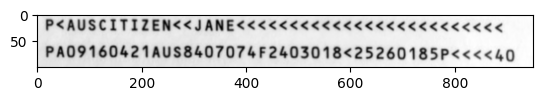

In [26]:
mrz,pts= extract_mrz(cropped_face_image,crop=False)

Angle: 0.00 degrees


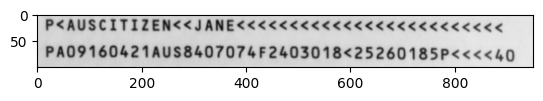

In [27]:
angle = detect_and_draw_horizontal_lines(mrz)

In [28]:
mrz.shape

(100, 951, 3)

In [29]:
import imutils
def rotate_image_new(image, angle):
  rotated = imutils.rotate_bound(image, angle)
  return rotated

In [30]:
rotated_mrz = rotate_image_new(mrz,-angle)

In [31]:
rotated_mrz.shape

(100, 951, 3)

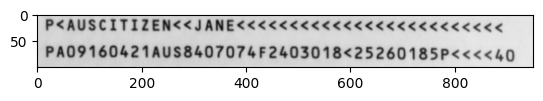

In [32]:
show_image(rotated_mrz)

In [33]:
#mrz box =  (23, 372, 943, 47)
#mrz box =  (92, 346, 787, 37)
# before expanding
# (23, 372, 943, 47)
# after expanding
# -15 343 1019 105

# y =  346
# before expanding
# (92, 346, 787, 37)
# after expanding
# 57 320 857 89

In [34]:
def retreive_data(mrz_row_list):
#     print(mrz_row_list)
    detail_dict = {}
    line1_words = mrz_row_list[0].split("<")
    line2_words = mrz_row_list[1].split("<")
    detail_dict["Name"] = " ".join(line1_words[2:]) + " "+ line1_words[1][3:]
    detail_dict["country_code"] = line1_words[1][:3]
    detail_dict["pp_no"] = line2_words[0][:9]
    detail_dict["nationality"] = line2_words[0][10:13]
    #detail_dict["data_of_birth"] = datetime.strptime(line2_words[0][13:19], "%y%m%d").strftime("%d-%m-%y")
    detail_dict["data_of_birth"] = line2_words[0][13:19]
    detail_dict["gender"] = line2_words[0][20:21]
    #detail_dict["expiry_date"] = datetime.strptime(line2_words[0][21:27], "%d%m%y").strftime("%d-%m-%y")
    detail_dict["expiry_date"] = line2_words[0][21:27]
    return detail_dict

In [35]:
def extract_text(mrz):
    mrzText = pytesseract.image_to_string(mrz,lang='eng')
    print("mrz text = ",mrzText)
    mrzlist=mrzText.split('\n')[:-1]
    print("mrz text = ",mrzText)
#     mrzlist = filter(None, mrzlist)
#     mrzlist = filter(bool, mrzlist)
#     mrzlist = filter(len, mrzlist)
#     mrzlist = filter(lambda item: item, mrzlist)
#     mrzlist = list(filter(None, mrzlist))
    mrzlist=' '.join(mrzlist).split()
    #mrzlist=[i for i in mrzlist if i]
    print("mrz list = ",mrzlist)
    data = retreive_data(mrzlist)
    df = pd.DataFrame(data.items(),columns = ["Passport Key","Value"])
    return df

In [36]:
df = extract_text(mrz)

mrz text =  P<AUSCITIZEN<K<JANEK<<< <<< KKK KKK KKK KKK KK KKK
PA09160421AUS8407074F2403018<25260185P<<<<40

mrz text =  P<AUSCITIZEN<K<JANEK<<< <<< KKK KKK KKK KKK KK KKK
PA09160421AUS8407074F2403018<25260185P<<<<40

mrz list =  ['P<AUSCITIZEN<K<JANEK<<<', '<<<', 'KKK', 'KKK', 'KKK', 'KKK', 'KK', 'KKK', 'PA09160421AUS8407074F2403018<25260185P<<<<40']


In [2096]:
display(df)

,Passport Key,Value
0,Name,ANNAKMARIA K ERIKSSON
1,country_code,UTO
2,pp_no,
3,nationality,
4,data_of_birth,
5,gender,
6,expiry_date,


In [1994]:
df = df.reset_index(drop=True)

In [1995]:
display(df)

,Passport Key,Value
0,Name,SPEC UK
1,country_code,GBR
2,pp_no,IMEN
3,nationality,
4,data_of_birth,
5,gender,
6,expiry_date,


In [1996]:
#del json_dict['index']

In [1997]:
df.to_json(os.path.join(f'../data/extraction_results/{filename}.json'))